### 5.3 Whole Slide Scoring - CNN Scores vs. CERAD-like Scores

A two-sided, independent, two-sample t-test was used to test the null hypothesis that two independent samples have identical expected values. CNN-based quantification scores of WSIs from different CERAD categories were used for the test. Data were presented as box plots overlaid with dot plot. Box plot plotted interquartile range (top and bottom of the box), median (the band inside the box), and outliers (points beyond the whiskers). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

from tqdm import tqdm

In [2]:
CSV_PATH = 'data/outputs/CNNscore/CNN_vs_CERAD.csv'
SAVE_DIR = 'data/outputs/CNNscore/'

In [3]:
CERAD_score_names = ['Cored_MTG', 'Diffuse_MTG', 'CAA_MTG']
CNN_score_names = ['CNN_cored_count', 'CNN_diffuse_count', 'CNN_caa_count']    
classes = ['cored plaque', 'diffuse plaque', 'CAA']

In [3]:
def get_significance_label(p):
    if p > 0.05:
        return 'n.s.'
    if p > 0.01:
        return '*'
    if p > 0.001: 
        return '**'
    if p > 0.0001:
        return '***'
    return '****'

In [4]:
def p_show(p):
    for i in range(2,15):
        if p > 1/10**i:
            return round(p, i+1)

In [9]:
cdict = {'red':   ((0.0, 0.0, 1.0),
                   (1.301/4, 0.7, 0.7),
                   (1.0, 0/255, 0.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.301/4, 0.7, 0.7),
                   (1.0, 100/255, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.301/4,0.7,0.7),
                   (1.0, 1.0, 0.0))
        }

colorbar = LinearSegmentedColormap('pvalue', cdict)

flierprops = dict(marker='+', markerfacecolor='red', markersize=12, markeredgecolor='red',
                  linestyle='none')

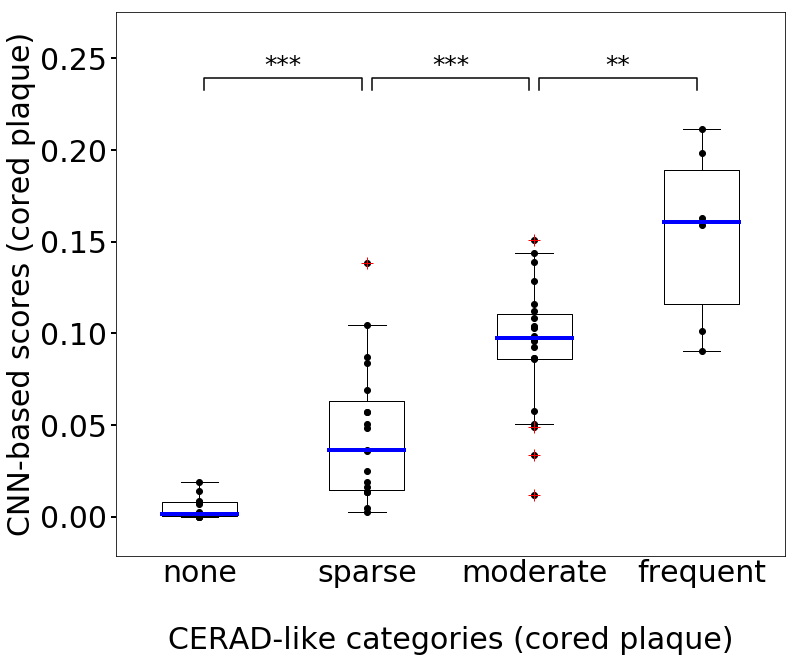

m, f:  Ttest_indResult(statistic=-3.4884107276773446, pvalue=0.0016828754329029586)
s, m:  Ttest_indResult(statistic=-4.285943237013092, pvalue=0.00011130227121476173)
n, s:  Ttest_indResult(statistic=-4.126990791726769, pvalue=0.00025634465197969634)
s, f:  Ttest_indResult(statistic=-5.728373515592623, pvalue=7.807664768297106e-06)
n, m:  Ttest_indResult(statistic=-9.528135536980566, pvalue=2.957030714162741e-11)
n, f:  Ttest_indResult(statistic=-11.548363513118643, pvalue=9.33490917172917e-10)


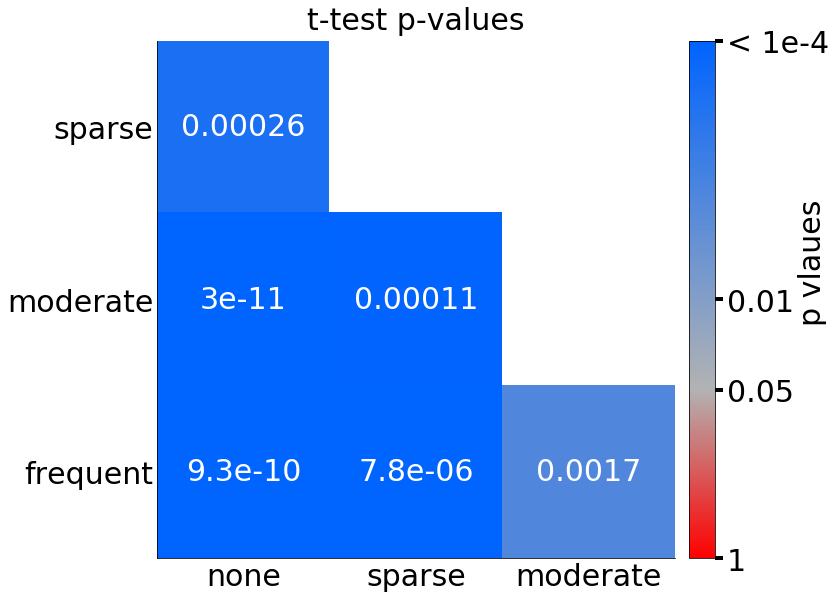

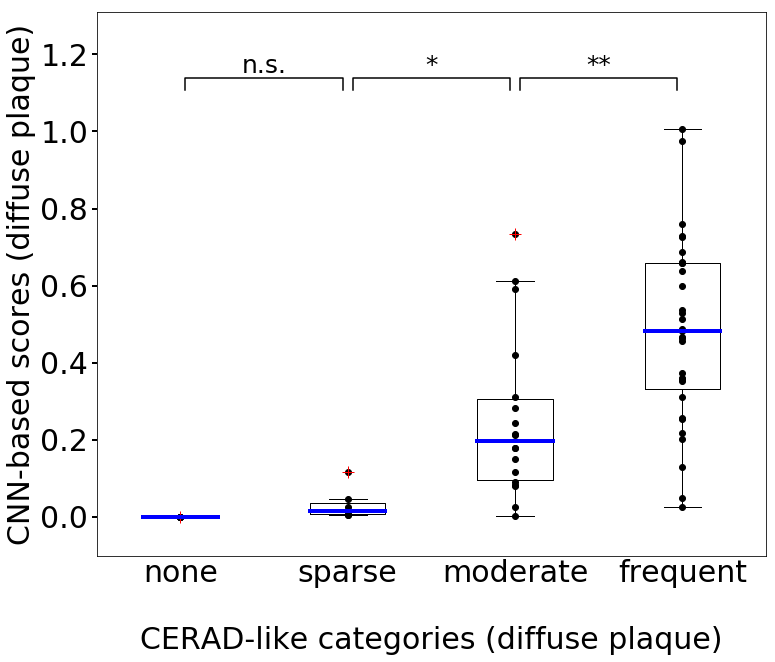

m, f:  Ttest_indResult(statistic=-3.36098719673028, pvalue=0.0015500584248134776)
s, m:  Ttest_indResult(statistic=-2.7168135635881923, pvalue=0.012300076284170361)
n, s:  Ttest_indResult(statistic=-1.888131717037888, pvalue=0.08565239844714927)
s, f:  Ttest_indResult(statistic=-4.854156841552069, pvalue=2.3441567479736343e-05)
n, m:  Ttest_indResult(statistic=-2.8846436861853317, pvalue=0.008603109328057362)
n, f:  Ttest_indResult(statistic=-4.814710638021004, pvalue=2.8042562794891484e-05)


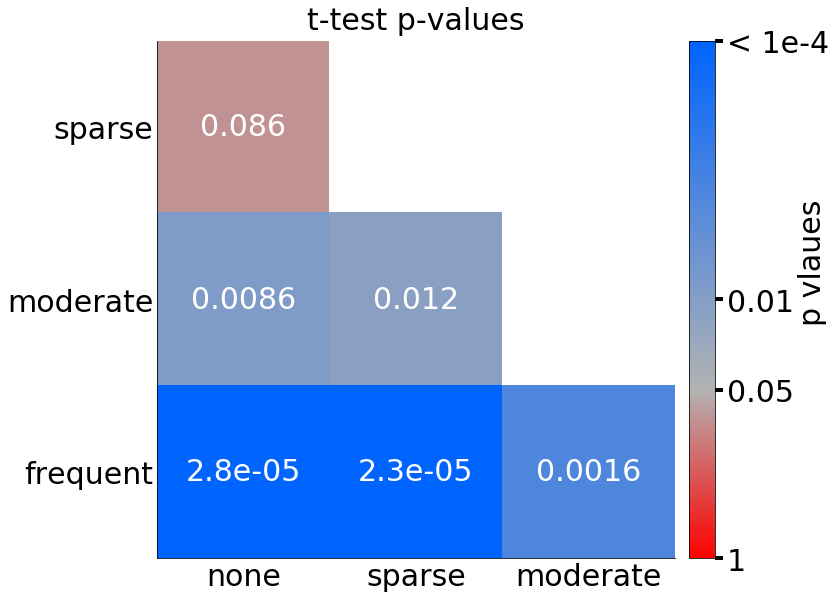

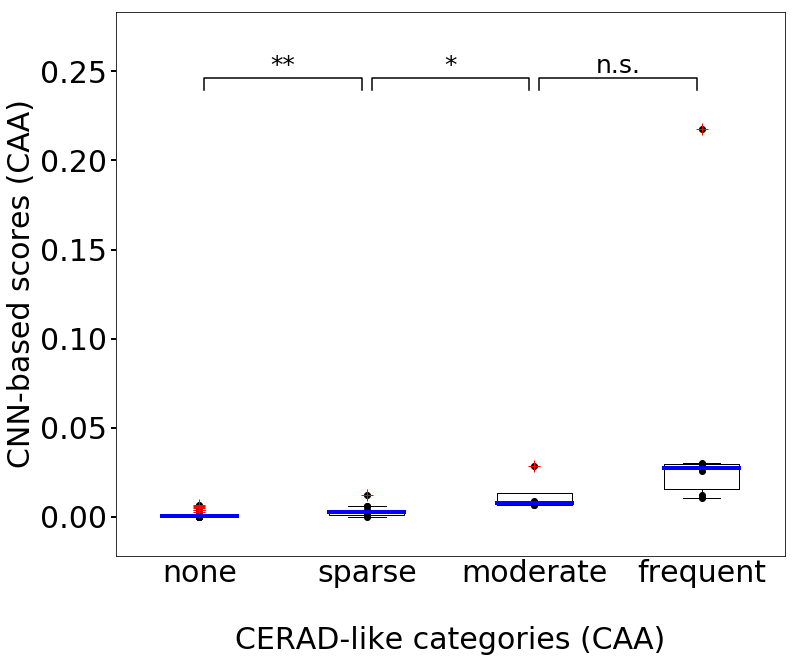

m, f:  Ttest_indResult(statistic=-1.0034802074937226, pvalue=0.34501201990683106)
s, m:  Ttest_indResult(statistic=-2.918297894964855, pvalue=0.010594024595358797)
n, s:  Ttest_indResult(statistic=-3.230092720998804, pvalue=0.0021897794924870886)
s, f:  Ttest_indResult(statistic=-2.345793707484794, pvalue=0.031373946255553474)
n, m:  Ttest_indResult(statistic=-6.560669560478103, pvalue=6.900705436044849e-08)
n, f:  Ttest_indResult(statistic=-4.389358028805531, pvalue=7.262266714063158e-05)


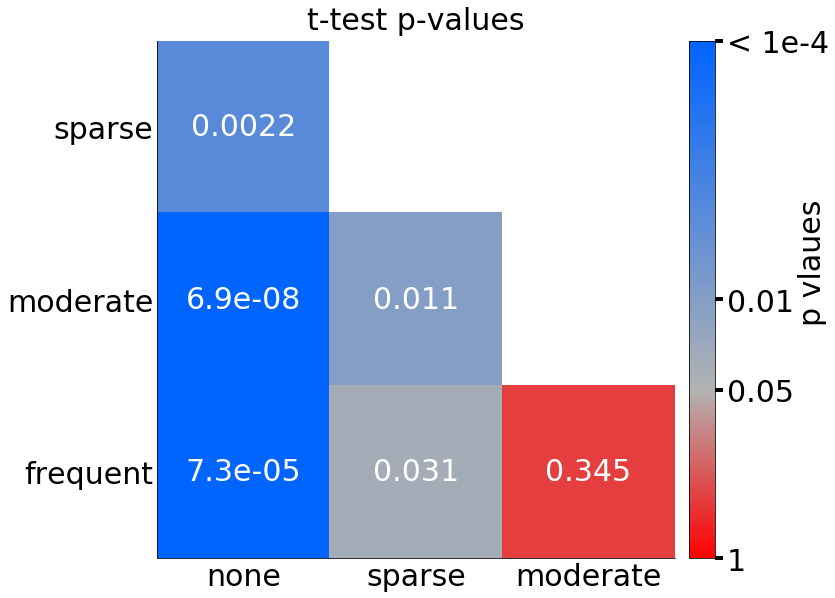

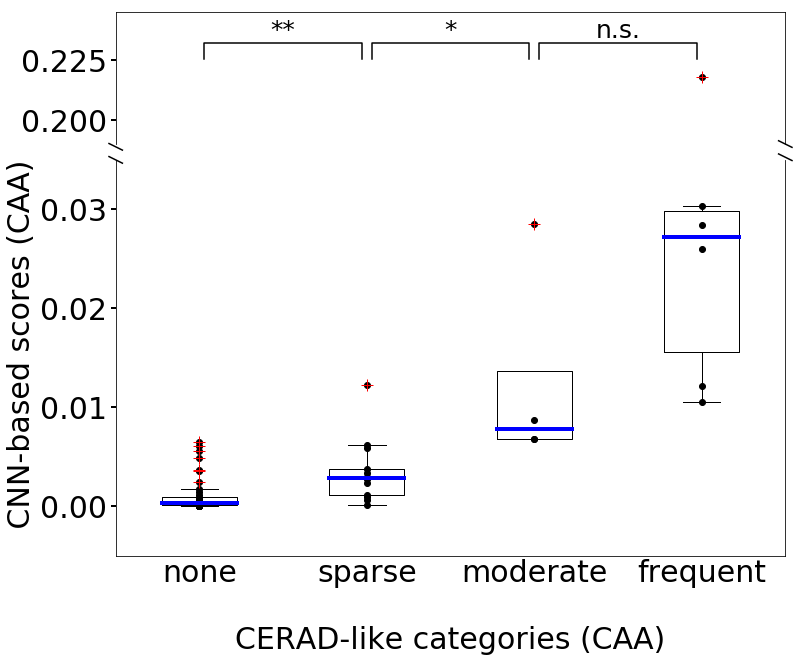

In [10]:
cnn_file = pd.read_csv(CSV_PATH)

for name in [0,1,2]:

    CERAD_score_name = CERAD_score_names[name]
    CNN_score_name = CNN_score_names[name]
    data = []
    scores = [0,1,2,3]
    for score in scores:

        count = np.asarray(cnn_file[cnn_file[CERAD_score_name]==score][CNN_score_name]) * 1000
        count = count / np.asarray(cnn_file[cnn_file[CERAD_score_name]==score]['Area'])
        count.shape = (-1,1)
        data.append(count[~np.isnan(count)])

    # box plot and dot plot
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
   
    bp = ax.boxplot(data, flierprops=flierprops, showmeans=False)
    for i in range(4):
        plt.setp(bp['medians'][i], color=(0,0,1), lw=4)
        ax.scatter([i+1 for _ in data[i]], data[i], c='k')
        
    # t test - calculate p-values
    p_values = np.ones([4,4])
    max_value = max([d.max() for d in data])
    for x in [1,2,3]:
        _, p = stats.ttest_ind(data[x-1], data[x], nan_policy='omit')
        p_values[x, x-1] = p
        # plot significance label
        x1, x2 = x+0.03, x+0.97   
        y, h, col = max_value*1.1, max_value*0.03, 'k'
        text = get_significance_label(p)
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=col, fontsize=25)
    for x in [1,2]:
        _, p = stats.ttest_ind(data[x-1], data[x+1], nan_policy='omit')
        p_values[x+1, x-1] = p
    _, p = stats.ttest_ind(data[0], data[3], nan_policy='omit')
    p_values[3, 0] = p

    ax.set_ylim([-max([d.max() for d in data])/10, max([d.max() for d in data])*1.3])
    _ = ax.set_xticklabels(['none', 'sparse', 'moderate', 'frequent'])
    ax.set_xlabel('\nCERAD-like categories ({})'.format(classes[name]), fontsize=30)
    ax.set_ylabel('CNN-based scores ({})'.format(classes[name]), fontsize=30)
    ax.xaxis.set_tick_params(labelsize=30, size=0, width=2)
    ax.yaxis.set_tick_params(labelsize=30, size=5, width=2)
    fig.savefig(SAVE_DIR+'box_plot_{}_entireset.png'.format(CNN_score_name), 
                bbox_inches='tight', dpi=300)
    plt.pause(0.001)
    
    # plot p-values matric
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    nlogp = -np.log10(p_values[1:, :3]) # only have 3x3 p-values
    mask = np.tri(nlogp.shape[0], k=0)
    nlogp = np.ma.array(nlogp, mask=1-mask)
    im = ax.imshow(nlogp, cmap=colorbar, vmin=0, vmax=4)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im, cax=cax, ticks=[0,1.30103,2,4])
    cbar.ax.tick_params(labelsize=30, size=8, width=4) 
    cbar.ax.set_yticklabels(['1','0.05','0.01','< 1e-4'])
    cbar.ax.text(4.2, 0.65, 'p vlaues', rotation=90, fontsize=30)
    
    for i in range(3):
        for j in range(0, i+1):
            text = ax.text(j, i, p_show(p_values[i+1,j]),
                           ha="center", va="center", color=(1,1,1), fontsize=30)
            
    ax.set_title('t-test p-values', fontsize=30, y=1.01)
    _ = plt.xticks([0,1,2], ['none', 'sparse', 'moderate'], fontsize=30)
    _ = plt.yticks([0,1,2], ['sparse', 'moderate', 'frequent'], fontsize=30)
    ax.xaxis.set_tick_params(labelsize=30, size=0, width=2)
    ax.yaxis.set_tick_params(labelsize=30, size=0, width=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
            
    fig.savefig(SAVE_DIR+'p_vaplus_{}_entireset.png'.format(CNN_score_name), 
                bbox_inches='tight', dpi=300)

    # print statistics
    print('m, f: ', stats.ttest_ind(data[2], data[3], nan_policy='omit'))
    print('s, m: ', stats.ttest_ind(data[1], data[2], nan_policy='omit'))
    print('n, s: ', stats.ttest_ind(data[0], data[1], nan_policy='omit'))
    print('s, f: ', stats.ttest_ind(data[1], data[3], nan_policy='omit'))
    print('n, m: ', stats.ttest_ind(data[0], data[2], nan_policy='omit'))
    print('n, f: ', stats.ttest_ind(data[0], data[3], nan_policy='omit'))